# Fluorescence assay prepared with a Tecan HP D300 digital dispenser

Experiment date: 2015/09/22 Protein: HSA Fluorescent ligand : dansyl glycine (lig2)

In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

In [3]:
import re
import pymc
import numpy as np

In [4]:
# Load data from Tecan iControl XML file.
from assaytools import platereader

row_names = ['A - HSA','B - Buffer','C - HSA','D - Buffer', 'E - HSA','F - Buffer','G - HSA','H - Buffer']

filename ="data/MI_FLU_hsa_lig2_20150922_164254.xml"

sections = platereader.read_icontrol_xml(filename)

print sections.keys()

['Abs_600', 'ex350_em480_topRead', 'ex350_em480_bottomRead']


In [10]:
# Extract observed fluorescence signals
complex_row = 'A'
ligand_row = 'B'

top_complex_fluorescence = sections['ex350_em480_topRead']['rows'][complex_row]
top_ligand_fluorescence = sections['ex350_em480_topRead']['rows'][ligand_row]
bottom_complex_fluorescence = sections['ex350_em480_bottomRead']['rows'][complex_row]
bottom_ligand_fluorescence = sections['ex350_em480_bottomRead']['rows'][ligand_row]

# Extract observed absorbance signals
ligand_ex_absorbance = sections['Abs_600']['rows'][ligand_row]
ligand_em_absorbance = sections['Abs_600']['rows'][ligand_row]

# Stated concentrations of protein and ligand.
Pstated = 0.5e-6 * np.ones([12],np.float64) # protein concentration, M
Lstated = 1e-6 * np.array([200.0000,86.6000,37.5000,16.2000,7.0200, 3.0400, 1.3200, 0.5700, 0.2470, 0.1070, 0.0462, 0.0200]) # ligand concentrations, M

In [11]:
# Assay configuration details
import math
assay_volume = 100e-6 # assay volume, L
#well_area = 0.3969 # well area, cm^2 for 4ti-0223 [http://4ti.co.uk/files/1614/0542/7662/4ti-0223_Marketing_Drawing.pdf]
ravg = (0.696/2. + 0.658/2.)/2. # average radius for Greiner UV-Star 96-well flat-bottom plates: http://www.greinerbioone.com/nl/belgium/files/1464609/655809.pdf
well_area = math.pi * ravg**2 
path_length = assay_volume * 1000 / well_area # cm, needed for inner filter effect corrections     

# Uncertainties in protein and ligand concentrations.
dPstated = 0.35 * Pstated # protein concentration uncertainty
dLstated = 0.08 * Lstated # ligand concentraiton uncertainty (due to gravimetric preparation and HP D300 dispensing)

In [12]:
# Create the pymc model
from assaytools import pymcmodels
pymc_model = pymcmodels.make_model(Pstated, dPstated, Lstated, dLstated, 
               top_complex_fluorescence=top_complex_fluorescence,
               top_ligand_fluorescence=top_ligand_fluorescence,
               bottom_complex_fluorescence=bottom_complex_fluorescence,
               bottom_ligand_fluorescence=bottom_ligand_fluorescence,
               use_primary_inner_filter_correction=False, 
               use_secondary_inner_filter_correction=False, 
               assay_volume=assay_volume, well_area=well_area, DG_prior='uniform',
#               ligand_ex_absorbance=ligand_ex_absorbance, ligand_em_absorbance=ligand_em_absorbance
            )

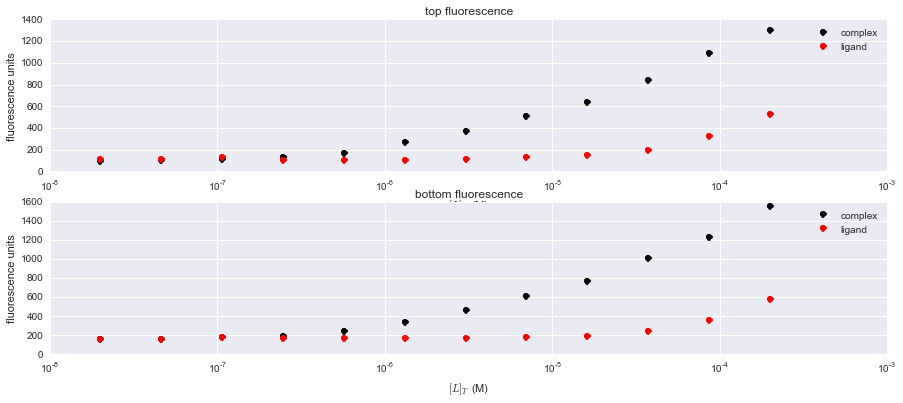

In [13]:
from assaytools import plots
figure = plots.plot_measurements(Lstated, Pstated, pymc_model)

In [14]:
# Find the maximum a posteriori fit (will only be local optimum, and several cycles are needed for reasonable fit)
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


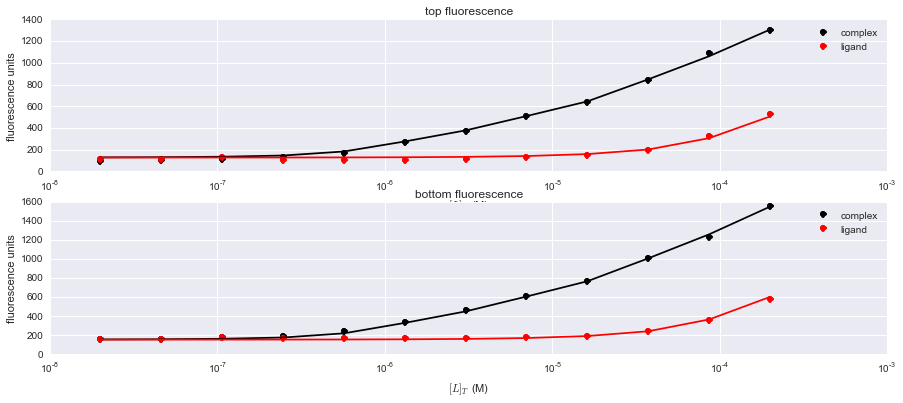

In [15]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [16]:
mcmc = pymc.MCMC(pymc_model, db='ram', name='Sampler', verbose=True)
nthin = 20
nburn = nthin*1000
niter = nthin*1000
mcmc.sample(iter=(nburn+niter), burn=nburn, thin=nthin, progress_bar=False, tune_throughout=False)

(1000,)


AttributeError: 'float' object has no attribute 'trace'

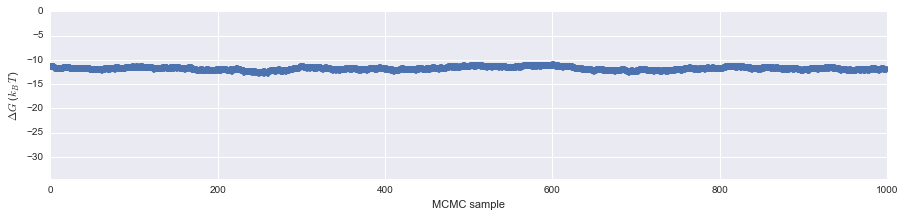

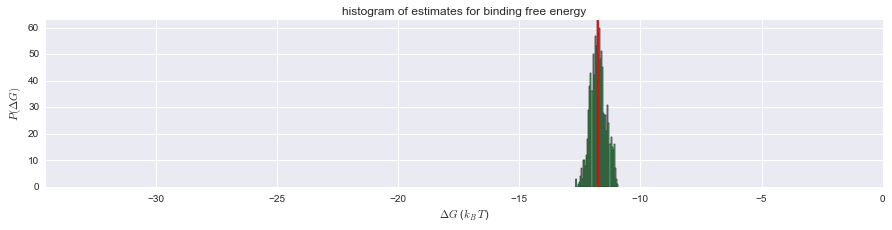

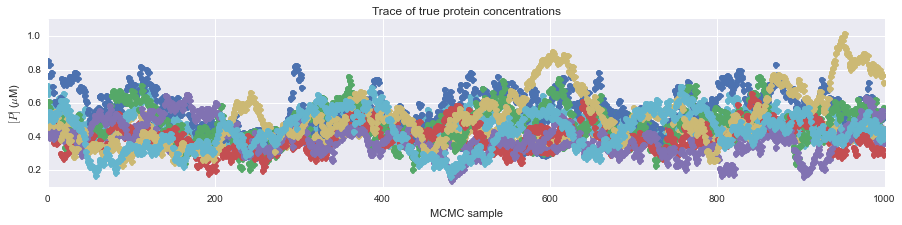

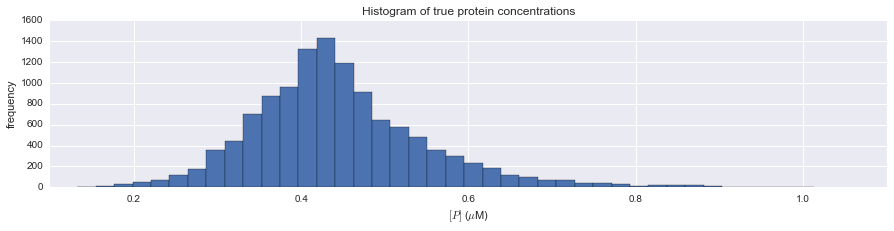

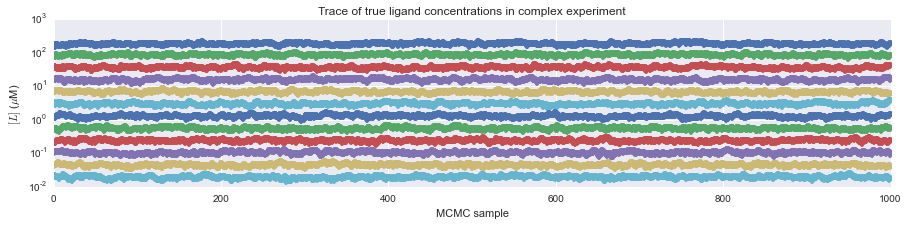

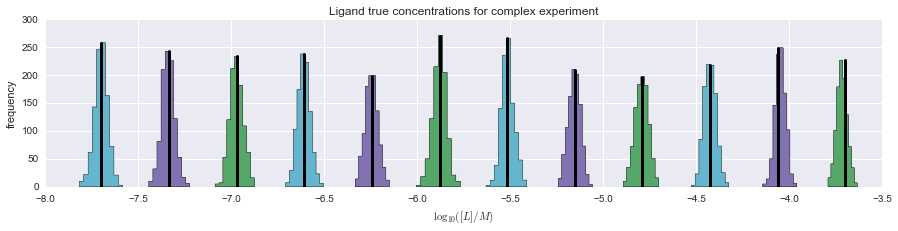

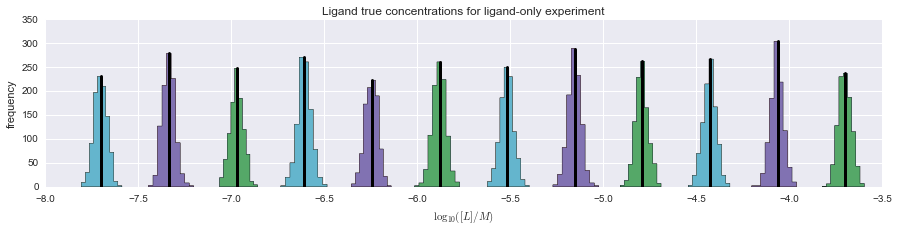

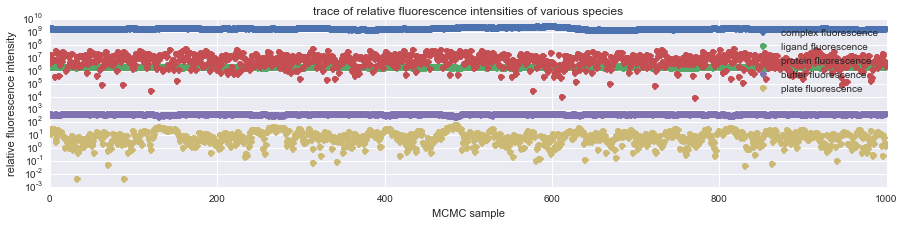

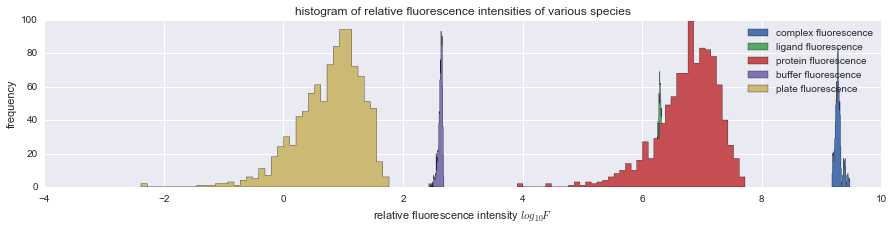

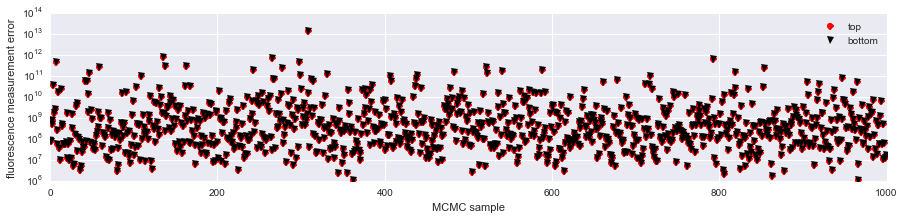

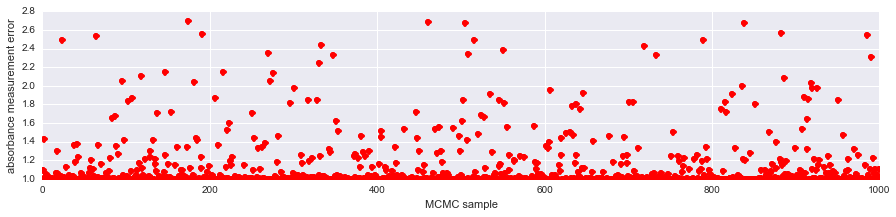

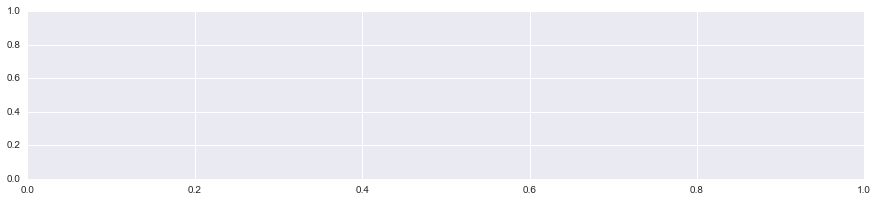

In [17]:
plots.plot_mcmc_results(Lstated, Pstated, path_length, mcmc)

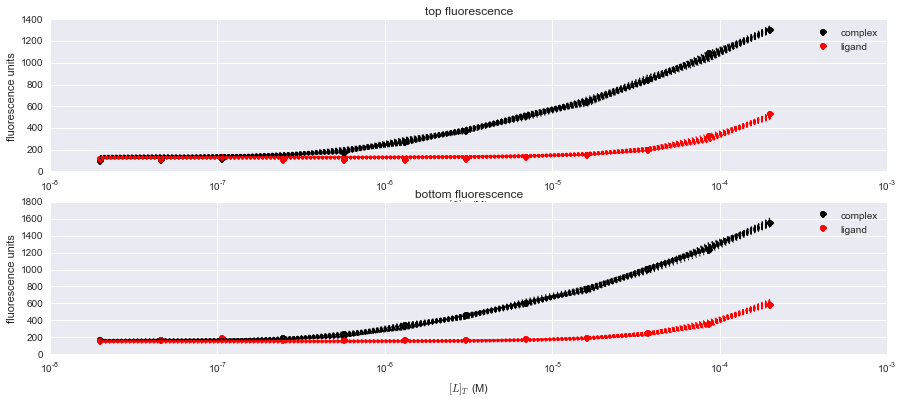

In [18]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, mcmc=mcmc)

In [19]:
# Fit maximum a posteriori estimate one more time
map = pymcmodels.map_fit(pymc_model)

MAP fitting cycle 5/5


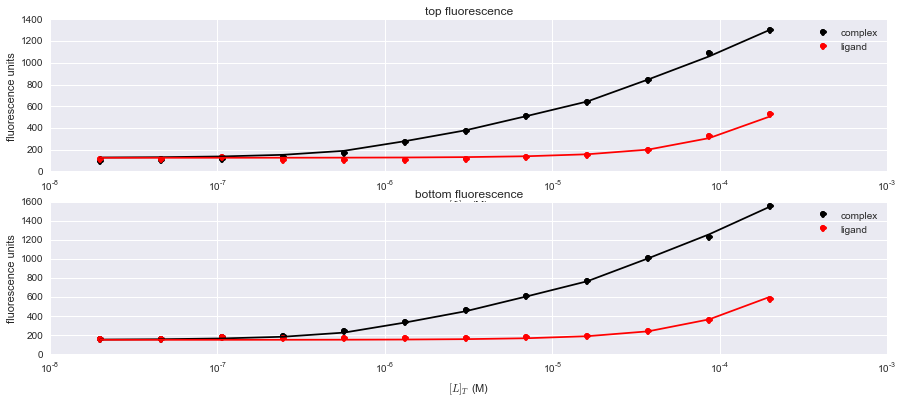

In [20]:
figure = plots.plot_measurements(Lstated, Pstated, pymc_model, map=map)

In [21]:
pymcmodels.show_summary(pymc_model, map, mcmc)

DeltaG = -12.0 +- 0.3 kT
Kd = 6.0 uM +- 2.7 uM
